In [1]:
import QUANTAXIS as QA
try:
    assert QA.__version__>='1.1.0'
except AssertionError:
    print('pip install QUANTAXIS >= 1.1.0 请升级QUANTAXIS后再运行此示例')

QUANTAXIS>> start QUANTAXIS
QUANTAXIS>> Welcome to QUANTAXIS, the Version is 1.1.0
QUANTAXIS>>  
 ```````````````````````````````````````````````````````````````````````````````````````````````````````````````````````` 
  ``########`````##````````##``````````##`````````####````````##```##########````````#``````##``````###```##`````######`` 
  `##``````## ```##````````##`````````####````````##`##```````##```````##```````````###``````##````##`````##```##`````##` 
  ##````````##```##````````##````````##`##````````##``##``````##```````##``````````####```````#```##``````##```##``````## 
  ##````````##```##````````##```````##```##```````##```##`````##```````##`````````##`##```````##`##```````##````##``````` 
  ##````````##```##````````##``````##`````##``````##````##````##```````##````````##``###```````###````````##`````##`````` 
  ##````````##```##````````##``````##``````##`````##`````##```##```````##```````##````##```````###````````##``````###```` 
  ##````````##```##````````##`````##``````

In [2]:
print('首先确定你已经完成了对于QUANTAXIS的基础认知,以及在本地存储完毕了QUANTAXIS的数据库')

首先确定你已经完成了对于QUANTAXIS的基础认知,以及在本地存储完毕了QUANTAXIS的数据库


# QUANTAXIS 回测的一些基础知识

##  QA回测的核心是两个类

```
QA_BacktestBroker
QA_Account
```

##  回测数据的引入/迭代

```
QA.QA_fetch_stock_day_adv
QA.QA_fetch_stock_min_adv
```

##  指标的计算

```
DataStruct.add_func
```

##  对于账户的灵活运用

```
QA_Account
QA_Risk
QA_Portfolio
QA_PortfolioView
QA_User
```

## STEP1 初始化账户,初始化回测broker

In [3]:
Account=QA.QA_Account()
Broker=QA.QA_BacktestBroker()

In [4]:
import warnings

In [5]:
# 打印账户的信息
try:
    from pprint import  pprint as print
except:
    pass
print(Account.message)

{'account_cookie': 'Acc_pgcuAewR',
 'allow_sellopen': False,
 'allow_t0': False,
 'broker': 'backtest',
 'cash': [1000000],
 'commission_coeff': 0.00025,
 'current_time': 'None',
 'history': [],
 'init_assets': {'cash': 1000000, 'hold': {}},
 'margin_level': False,
 'market_type': 'stock_cn',
 'portfolio_cookie': None,
 'quantaxis_version': '1.1.0',
 'running_environment': 'backtest',
 'running_time': '2018-08-18 00:52:07.746339',
 'source': 'account',
 'strategy_name': None,
 'tax_coeff': 0.0015,
 'trade_index': [],
 'user_cookie': None}


## 首先讲解Account类:

QA_Account在初始化的时候,可以自己指定很多信息:

```

    QA_Account(
        strategy_name=None, user_cookie=None, portfolio_cookie=None, account_cookie=None,
        market_type=MARKET_TYPE.STOCK_CN, frequence=FREQUENCE.DAY, broker=BROKER_TYPE.BACKETEST,
        init_hold={}, init_cash=1000000, commission_coeff=0.00025, tax_coeff=0.0015,
        margin_level=False, allow_t0=False, allow_sellopen=False,
        running_environment=RUNNING_ENVIRONMENT.BACKETEST)

        :param [str] strategy_name:  策略名称
        :param [str] user_cookie:   用户cookie
        :param [str] portfolio_cookie: 组合cookie
        :param [str] account_cookie:   账户cookie

        :param [dict] init_hold         初始化时的股票资产
        :param [float] init_cash:         初始化资金
        :param [float] commission_coeff:  交易佣金 :默认 万2.5   float 类型
        :param [float] tax_coeff:         印花税   :默认 千1.5   float 类型

        :param [Bool] margin_level:      保证金比例 默认False
        :param [Bool] allow_t0:          是否允许t+0交易  默认False
        :param [Bool] allow_sellopen:    是否允许卖空开仓  默认False

        :param [QA.PARAM] market_type:   市场类别 默认QA.MARKET_TYPE.STOCK_CN A股股票
        :param [QA.PARAM] frequence:     账户级别 默认日线QA.FREQUENCE.DAY
        :param [QA.PARAM] broker:        BROEKR类 默认回测 QA.BROKER_TYPE.BACKTEST
        :param [QA.PARAM] running_environment 当前运行环境 默认Backtest

        # 2018/06/11 init_assets 从float变为dict,并且不作为输入,作为只读属性
        #  :param [float] init_assets:       初始资产  默认 1000000 元 （100万）
        init_assets:{
            cash: xxx,
            stock: {'000001':2000},
            init_date: '2018-02-05',
            init_datetime: '2018-02-05 15:00:00'
        }
        # 2018/06/11 取消在初始化的时候的cash和history输入
        # :param [list] cash:              可用现金  默认 是 初始资产  list 类型
        # :param [list] history:           交易历史
```

In [6]:
# 重设账户初始资金

Account.reset_assets(200000)
Account.account_cookie='JCSC_EXAMPLE'

In [7]:
Account.init_assets

{'cash': 200000, 'hold': {}}

Account 有很多方法,暂时不详细展开,我们先直接进入下一步

# SETP2:引入回测的市场数据

引入方法非常简单,直接使用QA_fetch_stock_day_adv系列即可

- code 可以是多种多样的选取方式

```python
1. QA.QA_fetch_stock_list_adv().code.tolist() # 获取全市场的股票代码
2. QA.QA_fetch_stock_block_adv().get_block('云计算').code  # 按版块选取
3. code= ['000001','000002'] # 自己指定
```
- 数据获取后,to_qfq() 即可获得前复权数据

```python
data=DataSturct.to_qfq()
```

In [8]:
# QA.QA_fetch_stock_list_adv().code.tolist()
# QA.QA_fetch_stock_block_adv().get_block('云计算').code
codelist=QA.QA_fetch_stock_block_adv().get_block('云计算').code

In [9]:
data=QA.QA_fetch_stock_day_adv(codelist,'2017-09-01','2018-05-20')

In [10]:
data

< QA_DataStruct_Stock_day with 109 securities >

In [11]:
data=data.to_qfq()

In [12]:
# data.data

## STEP3:计算一些指标

指标的计算可以在回测前,也可以在回测中进行

回测前的计算则是批量计算,效率较高

回测中的计算,效率略低,但代码量较小,易于理解

PS: 指标的相关介绍参见 [QUANTAXIS的指标系统](https://github.com/QUANTAXIS/QUANTAXIS/blob/master/Documents/indicators.md)

In [13]:
import numpy as np
import pandas as pd
def MACD_JCSC(dataframe,SHORT=12,LONG=26,M=9):
    """
    1.DIF向上突破DEA，买入信号参考。
    2.DIF向下跌破DEA，卖出信号参考。
    """
    CLOSE=dataframe.close
    DIFF =QA.EMA(CLOSE,SHORT) - QA.EMA(CLOSE,LONG)
    DEA = QA.EMA(DIFF,M)
    MACD =2*(DIFF-DEA)

    CROSS_JC=QA.CROSS(DIFF,DEA)
    CROSS_SC=QA.CROSS(DEA,DIFF)
    ZERO=0
    return pd.DataFrame({'DIFF':DIFF,'DEA':DEA,'MACD':MACD,'CROSS_JC':CROSS_JC,'CROSS_SC':CROSS_SC,'ZERO':ZERO})

In [14]:
ind=data.add_func(MACD_JCSC)

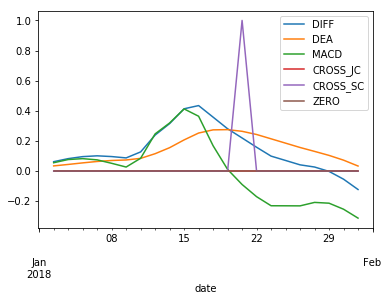

In [15]:
ind.xs(codelist[0],level=1)['2018-01'].plot()

In [16]:
ind.xs(codelist[0],level=1)['2018-01']

,DIFF,DEA,MACD,CROSS_JC,CROSS_SC,ZERO
date,,,,,,
2018-01-02,0.062832,0.034908,0.055848,0,0,0
2018-01-03,0.083081,0.044543,0.077076,0,0,0
2018-01-04,0.096405,0.054915,0.082979,0,0,0
2018-01-05,0.101761,0.064284,0.074953,0,0,0
2018-01-08,0.096831,0.070794,0.052074,0,0,0
2018-01-09,0.087880,0.074211,0.027338,0,0,0
2018-01-10,0.127678,0.084904,0.085548,0,0,0
2018-01-11,0.239488,0.115821,0.247333,0,0,0
2018-01-12,0.315590,0.155775,0.319631,0,0,0


In [17]:
ind.loc['2018-01',slice(None)]

DIFF       DEA      MACD  CROSS_JC  CROSS_SC  ZERO
date       code                                                          
2018-01-02 000021  0.062832  0.034908  0.055848         0         0     0
           000063  0.350531  0.539474 -0.377886         0         0     0
           000066 -0.103693 -0.164662  0.121938         0         0     0
           000070 -0.298122 -0.297769 -0.000706         0         0     0
           000100 -0.111283 -0.109635 -0.003296         0         0     0
           000555       NaN       NaN       NaN         0         0     0
           000611  0.085137  0.038461  0.093353         0         0     0
           000665 -0.128508 -0.179685  0.102356         0         0     0
           000836 -0.094147       NaN       NaN         0         0     0
           000938  1.251292  0.414957  1.672669         0         0     0
           000948 -0.138808 -0.163646  0.049677         0         0     0
           000977  0.147007  0.089165  0.115685         0         0     0
           002063 -0.000718 -0.041517  0.081599         0         0     0
           002065 -0.330897 -0.311772 -0.038251         0         0     0
           002093  0.071611  0.040341  0.062539         0         0     0
           002095 -0.141841 -0.246130  0.208579         0         0     0
           002195 -0.150915 -0.158826  0.015820         1         0     0
           002197 -0.039920 -0.026400 -0.027039         0         0     0
           002268 -0.282747 -0.095097 -0.375300         0         0     0
           002279 -0.207586 -0.179862 -0.055448         0         0     0
           002281  0.155791  0.417276 -0.522969         0         0     0
           002301 -0.029081  0.022214 -0.102589         0         0     0
           002315 -0.741722 -0.618039 -0.247365         0         0     0
           002335 -0.672783 -0.623881 -0.097803         0         0     0
           002368 -0.415162 -0.345593 -0.139139         0         0     0
           002396 -0.372709 -0.313333 -0.118752         0         0     0
           002415  0.137828  0.117979  0.039697         0         0     0
           002417 -0.315567 -0.213388 -0.204357         0         0     0
           002439 -0.110393  0.036686 -0.294157         0         0     0
           002456 -0.644033 -0.682755  0.077443         1         0     0
...                     ...       ...       ...       ...       ...   ...
2018-01-31 600225 -0.058853 -0.031449 -0.054807         0         0     0
           600289 -1.171529 -1.205996  0.068934         0         0     0
           600385 -0.338182 -0.307123 -0.062117         0         0     0
           600410 -0.088613 -0.075791 -0.025643         0         1     0
           600522 -0.557657 -0.468933 -0.177448         0         0     0
           600536 -0.648704 -0.408761 -0.479886         0         0     0
           600588  0.327150  0.199457  0.255386         0         0     0
           600589  0.004017  0.018157 -0.028280         0         1     0
           600590 -0.192047 -0.194900  0.005705         0         0     0
           600595 -0.069449 -0.013864 -0.111170         0         0     0
           600601 -0.071518 -0.047553 -0.047930         0         0     0
           600602 -0.020619  0.022803 -0.086844         0         0     0
           600633  0.138275  0.143204 -0.009859         0         1     0
           600718 -0.372869 -0.327002 -0.091732         0         0     0
           600728 -0.229074 -0.185714 -0.086721         0         0     0
           600756 -0.269601 -0.191433 -0.156336         0         0     0
           600767 -0.135812 -0.156087  0.040549         0         0     0
           600770 -0.135974 -0.112889 -0.046169         0         0     0
           600797 -0.134989 -0.070951 -0.128076         0         0     0
           600804 -0.353543 -0.371659  0.036233         0         0     0
           600845  0.292773  0.365709 -0.145873         0         0     0
           600850 -0.756647

# SETP4:选取回测的开始和结束日期,构建回测

In [18]:
data_forbacktest=data.select_time('2018-01-01','2018-05-01')


for items in data_forbacktest.panel_gen:
    for item in items.security_gen:
        daily_ind=ind.loc[item.index]
        if daily_ind.CROSS_JC.iloc[0]>0:
            order=Account.send_order(
                code=item.code[0], 
                time=item.date[0], 
                amount=1000, 
                towards=QA.ORDER_DIRECTION.BUY, 
                price=0, 
                order_model=QA.ORDER_MODEL.CLOSE, 
                amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                )
            #print(item.to_json()[0])
            Broker.receive_order(QA.QA_Event(order=order,market_data=item))
            
            
            trade_mes=Broker.query_orders(Account.account_cookie,'filled')
            res=trade_mes.loc[order.account_cookie,order.realorder_id]
            order.trade(res.trade_id,res.trade_price,res.trade_amount,res.trade_time)
        elif daily_ind.CROSS_SC.iloc[0]>0:
            if Account.sell_available.get(item.code[0], 0)>0:
                order=Account.send_order(
                    code=item.code[0], 
                    time=item.date[0], 
                    amount=Account.sell_available.get(item.code[0], 0), 
                    towards=QA.ORDER_DIRECTION.SELL, 
                    price=0, 
                    order_model=QA.ORDER_MODEL.MARKET, 
                    amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                    )
                Broker.receive_order(QA.QA_Event(order=order,market_data=item))


                trade_mes=Broker.query_orders(Account.account_cookie,'filled')
                res=trade_mes.loc[order.account_cookie,order.realorder_id]
                order.trade(res.trade_id,res.trade_price,res.trade_amount,res.trade_time)
    Account.settle()
            
        #break

['JCSC_EXAMPLE', '2018-01-02 00:00:00', '2018-01-02 00:00:00', '002195', None, 1, 5.91, 5.91, 'trade_success', 1000, 1000, 5915.0, 0, 'Order_AGZefuXd', 'Trade_UDtyK1Vm']
receive deal
['JCSC_EXAMPLE', '2018-01-02 00:00:00', '2018-01-02 00:00:00', '002456', None, 1, 20.78, 20.78, 'trade_success', 1000, 1000, 20785.195, 0, 'Order_qOuEB4fo', 'Trade_DkUcde6T']
receive deal
['JCSC_EXAMPLE', '2018-01-02 00:00:00', '2018-01-02 00:00:00', '002544', None, 1, 15.85, 15.85, 'trade_success', 1000, 1000, 15855.0, 0, 'Order_ripYwt6L', 'Trade_JfdrGHs7']
receive deal
['JCSC_EXAMPLE', '2018-01-02 00:00:00', '2018-01-02 00:00:00', '300290', None, 1, 8.71, 8.71, 'trade_success', 1000, 1000, 8715.0, 0, 'Order_ph50Tje9', 'Trade_OAMc0nCN']
receive deal
['JCSC_EXAMPLE', '2018-01-02 00:00:00', '2018-01-02 00:00:00', '300367', None, 1, 15.39, 15.39, 'trade_success', 1000, 1000, 15395.0, 0, 'Order_YvlByWfD', 'Trade_LbpR6WtI']
receive deal
['JCSC_EXAMPLE', '2018-01-02 00:00:00', '2018-01-02 00:00:00', '600105', N

['JCSC_EXAMPLE', '2018-01-23 00:00:00', '2018-01-23 00:00:00', '600797', None, -1, 12.25, 12.25, 'trade_success', 1000.0, 1000.0, 12273.375, 0, 'Order_1HcuVpjx', 'Trade_Fso2LJax']
receive deal
['JCSC_EXAMPLE', '2018-01-24 00:00:00', '2018-01-24 00:00:00', '000066', None, 1, 7.16, 7.16, 'trade_success', 1000, 1000, 7165.0, 0, 'Order_zp0JfaoD', 'Trade_qfxuYiHW']
receive deal
['JCSC_EXAMPLE', '2018-01-24 00:00:00', '2018-01-24 00:00:00', '000836', None, 1, 5.28, 5.28, 'trade_success', 1000, 1000, 5285.0, 0, 'Order_F6Pwb7Do', 'Trade_qV5j6vtw']
receive deal
['JCSC_EXAMPLE', '2018-01-24 00:00:00', '2018-01-24 00:00:00', '002268', None, 1, 23.6, 23.6, 'trade_success', 1000, 1000, 23605.9, 0, 'Order_cMeJrbuY', 'Trade_PGTxUoaf']
receive deal
5229.747500000029
NOT ENOUGH MONEY FOR Order_cMeJrbuY
['JCSC_EXAMPLE', '2018-01-24 00:00:00', '2018-01-24 00:00:00', '300036', None, 1, 15.46, 15.4591896377, 'trade_success', 1000, 1000, 15464.1896377, 0, 'Order_eXRzb7at', 'Trade_cfHJG5ut']
receive deal
522

['JCSC_EXAMPLE', '2018-02-22 00:00:00', '2018-02-22 00:00:00', '002642', None, 1, 10.67, 10.67, 'trade_success', 1000, 1000, 10675.0, 0, 'Order_zLProkqZ', 'Trade_ZRDUd6th']
receive deal
741.9075000000103
NOT ENOUGH MONEY FOR Order_zLProkqZ
['JCSC_EXAMPLE', '2018-02-22 00:00:00', '2018-02-22 00:00:00', '300036', None, 1, 13.75, 13.7470321247, 'trade_success', 1000, 1000, 13752.032124700001, 0, 'Order_mc9blrYv', 'Trade_nE6HODV1']
receive deal
741.9075000000103
NOT ENOUGH MONEY FOR Order_mc9blrYv
['JCSC_EXAMPLE', '2018-02-22 00:00:00', '2018-02-22 00:00:00', '300078', None, 1, 8.3, 8.3, 'trade_success', 1000, 1000, 8305.0, 0, 'Order_g1z5AZUW', 'Trade_AMEVfKTc']
receive deal
741.9075000000103
NOT ENOUGH MONEY FOR Order_g1z5AZUW
['JCSC_EXAMPLE', '2018-02-22 00:00:00', '2018-02-22 00:00:00', '300229', None, 1, 12.36, 12.36, 'trade_success', 1000, 1000, 12365.0, 0, 'Order_dIQtrTWz', 'Trade_FhtGNMuq']
receive deal
741.9075000000103
NOT ENOUGH MONEY FOR Order_dIQtrTWz
['JCSC_EXAMPLE', '2018-02-

['JCSC_EXAMPLE', '2018-03-07 00:00:00', '2018-03-07 00:00:00', '300113', None, -1, 22.67, 22.67, 'trade_success', 1000.0, 1000.0, 22709.6725, 0, 'Order_cDrkeblm', 'Trade_IxeuwnMH']
receive deal
['JCSC_EXAMPLE', '2018-03-09 00:00:00', '2018-03-07 00:00:00', '000948', None, 1, 0.0, 9.9, 'trade_price_limit', 1000, 0, 5, 0, 'Order_f512YgQF', 'Trade_8OZJwhQI']
['JCSC_EXAMPLE', '2018-03-09 00:00:00', '2018-03-09 00:00:00', '300212', None, 1, 33.08, 33.08, 'trade_success', 1000, 1000, 33088.27, 0, 'Order_QZSuPY2A', 'Trade_j38HQRl0']
receive deal
['JCSC_EXAMPLE', '2018-03-12 00:00:00', '2018-03-12 00:00:00', '300113', None, 1, 24.08, 24.08, 'trade_success', 1000, 1000, 24086.02, 0, 'Order_OZ87YLkF', 'Trade_5ZVaqfRy']
receive deal
['JCSC_EXAMPLE', '2018-03-14 00:00:00', '2018-03-14 00:00:00', '300113', None, -1, 23.7, 23.695, 'trade_success', 1000.0, 1000.0, 23736.46625, 0, 'Order_MOFWBefc', 'Trade_DuLSBUKA']
receive deal
['JCSC_EXAMPLE', '2018-03-14 00:00:00', '2018-03-14 00:00:00', '300212', 

receive deal
2635.215000000034
NOT ENOUGH MONEY FOR Order_DIMOjqz3
['JCSC_EXAMPLE', '2018-04-02 00:00:00', '2018-04-02 00:00:00', '600410', None, 1, 12.22, 12.22, 'trade_success', 1000, 1000, 12225.0, 0, 'Order_7ksGX1bp', 'Trade_4uGitzmZ']
receive deal
2635.215000000034
NOT ENOUGH MONEY FOR Order_7ksGX1bp
['JCSC_EXAMPLE', '2018-04-02 00:00:00', '2018-04-02 00:00:00', '600601', None, 1, 3.22, 3.22, 'trade_success', 1000, 1000, 3225.0, 0, 'Order_1pon7FMg', 'Trade_lrG1WN7U']
receive deal
2635.215000000034
NOT ENOUGH MONEY FOR Order_1pon7FMg
['JCSC_EXAMPLE', '2018-04-03 00:00:00', '2018-04-03 00:00:00', '002195', None, 1, 5.85, 5.85, 'trade_success', 1000, 1000, 5855.0, 0, 'Order_fCDH3WKc', 'Trade_tNALEa2S']
receive deal
2635.215000000034
NOT ENOUGH MONEY FOR Order_fCDH3WKc
['JCSC_EXAMPLE', '2018-04-03 00:00:00', '2018-04-03 00:00:00', '002197', None, 1, 10.36, 10.36, 'trade_success', 1000, 1000, 10365.0, 0, 'Order_zgF9w8RD', 'Trade_twVOUfD1']
receive deal
2635.215000000034
NOT ENOUGH MONE

['JCSC_EXAMPLE', '2018-04-23 00:00:00', '2018-04-23 00:00:00', '600601', None, -1, 3.08, 3.075, 'trade_success', 1000.0, 1000.0, 3084.6125, 0, 'Order_dtTBM43Y', 'Trade_wPmDI0Zn']
receive deal
['JCSC_EXAMPLE', '2018-04-24 00:00:00', '2018-04-24 00:00:00', '000948', None, 1, 11.59, 11.59, 'trade_success', 1000, 1000, 11595.0, 0, 'Order_CdiZN1Of', 'Trade_pSFE5gtI']
receive deal
5620.430000000044
NOT ENOUGH MONEY FOR Order_CdiZN1Of
['JCSC_EXAMPLE', '2018-04-24 00:00:00', '2018-04-24 00:00:00', '300274', None, 1, 18.79, 18.79, 'trade_success', 1000, 1000, 18795.0, 0, 'Order_rs4xkhe5', 'Trade_VtPGXMBf']
receive deal
5620.430000000044
NOT ENOUGH MONEY FOR Order_rs4xkhe5
['JCSC_EXAMPLE', '2018-04-24 00:00:00', '2018-04-24 00:00:00', '600601', None, 1, 3.08, 3.08, 'trade_success', 1000, 1000, 3085.0, 0, 'Order_xrFNEVC4', 'Trade_nN2dklEI']
receive deal
['JCSC_EXAMPLE', '2018-04-25 00:00:00', '2018-04-25 00:00:00', '002197', None, 1, 10.35, 10.35, 'trade_success', 1000, 1000, 10355.0, 0, 'Order_k

## STEP5: 分析账户

In [19]:
Account.history

[['2018-01-02 00:00:00',
  '002195',
  5.91,
  1000,
  194079.6575,
  'Order_AGZefuXd',
  'Order_AGZefuXd',
  'Trade_7RxnPTq1',
  'JCSC_EXAMPLE',
  1.4775,
  8.865],
 ['2018-01-02 00:00:00',
  '002456',
  20.78,
  1000,
  173263.2925,
  'Order_qOuEB4fo',
  'Order_qOuEB4fo',
  'Trade_5IZEW2LB',
  'JCSC_EXAMPLE',
  5.195,
  31.17],
 ['2018-01-02 00:00:00',
  '002544',
  15.85,
  1000,
  157385.55500000002,
  'Order_ripYwt6L',
  'Order_ripYwt6L',
  'Trade_VzvpFjPM',
  'JCSC_EXAMPLE',
  3.9625,
  23.775000000000002],
 ['2018-01-02 00:00:00',
  '300290',
  8.71,
  1000,
  148660.31250000003,
  'Order_ph50Tje9',
  'Order_ph50Tje9',
  'Trade_vWYaMmhq',
  'JCSC_EXAMPLE',
  2.1775,
  13.065],
 ['2018-01-02 00:00:00',
  '300367',
  15.39,
  1000,
  133243.38000000003,
  'Order_YvlByWfD',
  'Order_YvlByWfD',
  'Trade_zWlyg0UM',
  'JCSC_EXAMPLE',
  3.8475,
  23.085],
 ['2018-01-02 00:00:00',
  '600105',
  6.58,
  1000,
  126651.86500000003,
  'Order_8sBTIvLO',
  'Order_8sBTIvLO',
  'Trade_cay7rZ6J

In [20]:
Account.history_table

,datetime,code,price,amount,cash,order_id,realorder_id,trade_id,account_cookie,commission,tax
0,2018-01-02 00:00:00,002195,5.91,1000,194079.6575,Order_AGZefuXd,Order_AGZefuXd,Trade_7RxnPTq1,JCSC_EXAMPLE,1.4775,8.865
1,2018-01-02 00:00:00,002456,20.78,1000,173263.2925,Order_qOuEB4fo,Order_qOuEB4fo,Trade_5IZEW2LB,JCSC_EXAMPLE,5.1950,31.170
2,2018-01-02 00:00:00,002544,15.85,1000,157385.5550,Order_ripYwt6L,Order_ripYwt6L,Trade_VzvpFjPM,JCSC_EXAMPLE,3.9625,23.775
3,2018-01-02 00:00:00,300290,8.71,1000,148660.3125,Order_ph50Tje9,Order_ph50Tje9,Trade_vWYaMmhq,JCSC_EXAMPLE,2.1775,13.065
4,2018-01-02 00:00:00,300367,15.39,1000,133243.3800,Order_YvlByWfD,Order_YvlByWfD,Trade_zWlyg0UM,JCSC_EXAMPLE,3.8475,23.085
5,2018-01-02 00:00:00,600105,6.58,1000,126651.8650,Order_8sBTIvLO,Order_8sBTIvLO,Trade_cay7rZ6J,JCSC_EXAMPLE,1.6450,9.870
6,2018-01-02 00:00:00,600797,11.87,1000,114761.0925,Order_whQIWHBi,Order_whQIWHBi,Trade_NtWVGFSo,JCSC_EXAMPLE,2.9675,17.805
7,2018-01-03 00:00:00,000070,9.52,1000,105224.4325,Order_wDPTJiRh,Order_wDPTJiRh,Trade_eufovKcX,JCSC_EXAMPLE,2.3800,14.280
8,2018-01-03 00:00:00,000100,3.99,1000,101227.4500,Order_f8yNTPHe,Order_f8yNTPHe,Trade_OUEDoFnu,JCSC_EXAMPLE,0.9975,5.985
9,2018-01-03 00:00:00,002065,8.53,1000,92682.5225,Order_x5k8PvbA,Order_x5k8PvbA,Trade_dBbge5v4,JCSC_EXAMPLE,2.1325,12.795


In [21]:
Account.daily_hold

,code,000063,000066,000070,000100,000611,000836,000977,002063,002065,002095,...,600601,600718,600770,600797,600804,600845,600996,601360,601928,603138
date,account_cookie,,,,,,,,,,,,,,,,,,,,,
2018-01-02,JCSC_EXAMPLE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-03,JCSC_EXAMPLE,0.0,0.0,1000.0,1000.0,0.0,0.0,0.0,0.0,1000.0,0.0,...,0.0,1000.0,0.0,1000.0,1000.0,0.0,0.0,0.0,0.0,0.0
2018-01-09,JCSC_EXAMPLE,0.0,0.0,1000.0,1000.0,0.0,0.0,0.0,0.0,1000.0,0.0,...,0.0,1000.0,0.0,1000.0,1000.0,0.0,0.0,0.0,0.0,0.0
2018-01-10,JCSC_EXAMPLE,0.0,0.0,1000.0,1000.0,0.0,0.0,0.0,0.0,1000.0,0.0,...,0.0,1000.0,0.0,1000.0,1000.0,0.0,0.0,0.0,0.0,0.0
2018-01-12,JCSC_EXAMPLE,0.0,0.0,1000.0,1000.0,0.0,0.0,0.0,0.0,1000.0,0.0,...,0.0,1000.0,0.0,1000.0,1000.0,0.0,0.0,0.0,0.0,0.0
2018-01-15,JCSC_EXAMPLE,0.0,0.0,1000.0,1000.0,0.0,0.0,0.0,0.0,1000.0,0.0,...,0.0,1000.0,0.0,1000.0,1000.0,0.0,0.0,0.0,0.0,0.0
2018-01-16,JCSC_EXAMPLE,1000.0,0.0,1000.0,1000.0,0.0,0.0,0.0,0.0,1000.0,0.0,...,0.0,0.0,0.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-17,JCSC_EXAMPLE,1000.0,0.0,1000.0,1000.0,0.0,0.0,0.0,0.0,1000.0,0.0,...,0.0,0.0,0.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-19,JCSC_EXAMPLE,0.0,0.0,1000.0,1000.0,0.0,0.0,0.0,0.0,1000.0,0.0,...,0.0,0.0,0.0,1000.0,1000.0,0.0,0.0,0.0,0.0,0.0


In [22]:
Risk=QA.QA_Risk(Account)

In [23]:
Risk.message

{'account_cookie': 'JCSC_EXAMPLE',
 'portfolio_cookie': None,
 'user_cookie': None,
 'annualize_return': -0.16,
 'profit': -0.05,
 'max_dropback': 0.12,
 'time_gap': 77,
 'volatility': 0.37,
 'benchmark_code': '000300',
 'bm_annualizereturn': -0.26,
 'bn_profit': -0.07,
 'beta': 1.0,
 'alpha': 0.1,
 'sharpe': -0.57,
 'init_cash': '200000.00',
 'last_assets': '190028.06',
 'total_tax': -224.52,
 'total_commission': -37.42,
 'profit_money': -9971.94}

In [24]:
Risk.market_value.diff().iloc[-1]

code
000063        0.0
000066        0.0
000070        0.0
000100        0.0
000611      -10.0
000836     -230.0
000977        0.0
002063   -11720.0
002065      -90.0
002095        0.0
002195        0.0
002279        0.0
002335        0.0
002396        0.0
002417        0.0
002456        0.0
002463      -60.0
002544        0.0
002837        0.0
300025      140.0
300036        0.0
300044        0.0
300051        0.0
300052        0.0
300085        0.0
300113        0.0
300212        0.0
300229        0.0
300235     -670.0
300245       10.0
300287        0.0
300290        0.0
300297        0.0
300365        0.0
300366       10.0
300367        0.0
300383        0.0
300431        0.0
300738        0.0
600100      -60.0
600105        0.0
600198     -430.0
600225        0.0
600589      140.0
600590        0.0
600595       30.0
600601     -310.0
600718        0.0
600770        0.0
600797        0.0
600804      -10.0
600845        0.0
600996       50.0
601360   -39040.0
601928        0.0
60313

In [25]:
Risk.account.cash_table

cash             datetime       date  \
datetime            account_cookie                                            
2018-01-02 00:00:00 JCSC_EXAMPLE     194080  2018-01-02 00:00:00 2018-01-02   
                    JCSC_EXAMPLE     173263  2018-01-02 00:00:00 2018-01-02   
                    JCSC_EXAMPLE     157386  2018-01-02 00:00:00 2018-01-02   
                    JCSC_EXAMPLE     148660  2018-01-02 00:00:00 2018-01-02   
                    JCSC_EXAMPLE     133243  2018-01-02 00:00:00 2018-01-02   
                    JCSC_EXAMPLE     126652  2018-01-02 00:00:00 2018-01-02   
                    JCSC_EXAMPLE     114761  2018-01-02 00:00:00 2018-01-02   
2018-01-03 00:00:00 JCSC_EXAMPLE     105224  2018-01-03 00:00:00 2018-01-03   
                    JCSC_EXAMPLE     101227  2018-01-03 00:00:00 2018-01-03   
                    JCSC_EXAMPLE    92682.5  2018-01-03 00:00:00 2018-01-03   
                    JCSC_EXAMPLE      62590  2018-01-03 00:00:00 2018-01-03   
                    JCSC_EXAMPLE    46782.3  2018-01-03 00:00:00 2018-01-03   
                    JCSC_EXAMPLE      35112  2018-01-03 00:00:00 2018-01-03   
                    JCSC_EXAMPLE    20085.7  2018-01-03 00:00:00 2018-01-03   
                    JCSC_EXAMPLE    2124.32  2018-01-03 00:00:00 2018-01-03   
2018-01-09 00:00:00 JCSC_EXAMPLE    17060.4  2018-01-09 00:00:00 2018-01-09   
2018-01-10 00:00:00 JCSC_EXAMPLE    3236.27  2018-01-10 00:00:00 2018-01-10   
2018-01-12 00:00:00 JCSC_EXAMPLE      23111  2018-01-12 00:00:00 2018-01-12   
                    JCSC_EXAMPLE    7233.25  2018-01-12 00:00:00 2018-01-12   
2018-01-15 00:00:00 JCSC_EXAMPLE    21748.6  2018-01-15 00:00:00 2018-01-15   
                    JCSC_EXAMPLE      35152  2018-01-15 00:00:00 2018-01-15   
                    JCSC_EXAMPLE    43246.2  2018-01-15 00:00:00 2018-01-15   
                    JCSC_EXAMPLE    53874.7  2018-01-15 00:00:00 2018-01-15   
2018-01-16 00:00:00 JCSC_EXAMPLE    15207.2  2018-01-16 00:00:00 2018-01-16   
                    JCSC_EXAMPLE    29852.8  2018-01-16 00:00:00 2018-01-16   
                    JCSC_EXAMPLE    44147.7  2018-01-16 00:00:00 2018-01-16   
                    JCSC_EXAMPLE    60686.6  2018-01-16 00:00:00 2018-01-16   
2018-01-17 00:00:00 JCSC_EXAMPLE    51109.9  2018-01-17 00:00:00 2018-01-17   
2018-01-19 00:00:00 JCSC_EXAMPLE    88034.4  2018-01-19 00:00:00 2018-01-19   
                    JCSC_EXAMPLE    77686.3  2018-01-19 00:00:00 2018-01-19   
...                                     ...                  ...        ...   
2018-04-12 00:00:00 JCSC_EXAMPLE    421.348  2018-04-12 00:00:00 2018-04-12   
2018-04-13 00:00:00 JCSC_EXAMPLE    16789.9  2018-04-13 00:00:00 2018-04-13   
                    JCSC_EXAMPLE    6972.79  2018-04-13 00:00:00 2018-04-13   
                    JCSC_EXAMPLE    24753.9  2018-04-13 00:00:00 2018-04-13   
                    JCSC_EXAMPLE    19274.3  2018-04-13 00:00:00 2018-04-13   
                    JCSC_EXAMPLE    7143.09  2018-04-13 00:00:00 2018-04-13   
                    JCSC_EXAMPLE    14425.8  2018-04-13 00:00:00 2018-04-13   
2018-04-16 00:00:00 JCSC_EXAMPLE    6011.11  2018-04-16 00:00:00 2018-04-16   
2018-04-17 00:00:00 JCSC_EXAMPLE    15587.8  2018-04-17 00:00:00 2018-04-17   
                    JCSC_EXAMPLE    20967.2  2018-04-17 00:00:00 2018-04-17   
                    JCSC_EXAMPLE    28099.7  2018-04-17 00:00:00 2018-04-17   
2018-04-18 00:00:00 JCSC_EXAMPLE    23742.1  2018-04-18 00:00:00 2018-04-18   
                    JCSC_EXAMPLE    11721.1  2018-04-18 00:00:00 2018-04-18   
                    JCSC_EXAMPLE    962.293  2018-04-18 00:00:00 2018-04-18   
2018-04-20 00:00:00 JCSC_EXAMPLE    12272.1  2018-04-20 00:00:00 2018-04-20   
                    JCSC_EXAMPLE    6792.48  2018-04-20 00:00:00 2018-04-20   
                    JCSC_EXAMPLE    18102.2  2018-04-20 00:00:00 2018-04-20   
                    JCSC_EXAMPLE    15006.8  2018-04-20 00:00:00 2018-04-20   
2018-04-23

In [26]:
Risk.market_value.sum(axis=1)

date        account_cookie
2018-01-02  JCSC_EXAMPLE       85090.000000
2018-01-03  JCSC_EXAMPLE      199920.000000
2018-01-09  JCSC_EXAMPLE      181770.000000
2018-01-10  JCSC_EXAMPLE      195190.000000
2018-01-12  JCSC_EXAMPLE      192210.000000
2018-01-15  JCSC_EXAMPLE      140640.000000
2018-01-16  JCSC_EXAMPLE      134750.000000
2018-01-17  JCSC_EXAMPLE      139840.000000
2018-01-19  JCSC_EXAMPLE      137370.000000
2018-01-22  JCSC_EXAMPLE      193990.000000
2018-01-23  JCSC_EXAMPLE      180630.000000
2018-01-24  JCSC_EXAMPLE      200790.000000
2018-01-25  JCSC_EXAMPLE      203080.000000
2018-01-29  JCSC_EXAMPLE      197540.000000
2018-01-31  JCSC_EXAMPLE      156950.000000
2018-02-01  JCSC_EXAMPLE       86030.000000
2018-02-02  JCSC_EXAMPLE      161320.000000
2018-02-06  JCSC_EXAMPLE      115810.000000
2018-02-07  JCSC_EXAMPLE      141093.410774
2018-02-08  JCSC_EXAMPLE      168030.978742
2018-02-12  JCSC_EXAMPLE      190451.008401
2018-02-22  JCSC_EXAMPLE      208569.911021
2018-

In [27]:
Account.history_table

,datetime,code,price,amount,cash,order_id,realorder_id,trade_id,account_cookie,commission,tax
0,2018-01-02 00:00:00,002195,5.91,1000,194079.6575,Order_AGZefuXd,Order_AGZefuXd,Trade_7RxnPTq1,JCSC_EXAMPLE,1.4775,8.865
1,2018-01-02 00:00:00,002456,20.78,1000,173263.2925,Order_qOuEB4fo,Order_qOuEB4fo,Trade_5IZEW2LB,JCSC_EXAMPLE,5.1950,31.170
2,2018-01-02 00:00:00,002544,15.85,1000,157385.5550,Order_ripYwt6L,Order_ripYwt6L,Trade_VzvpFjPM,JCSC_EXAMPLE,3.9625,23.775
3,2018-01-02 00:00:00,300290,8.71,1000,148660.3125,Order_ph50Tje9,Order_ph50Tje9,Trade_vWYaMmhq,JCSC_EXAMPLE,2.1775,13.065
4,2018-01-02 00:00:00,300367,15.39,1000,133243.3800,Order_YvlByWfD,Order_YvlByWfD,Trade_zWlyg0UM,JCSC_EXAMPLE,3.8475,23.085
5,2018-01-02 00:00:00,600105,6.58,1000,126651.8650,Order_8sBTIvLO,Order_8sBTIvLO,Trade_cay7rZ6J,JCSC_EXAMPLE,1.6450,9.870
6,2018-01-02 00:00:00,600797,11.87,1000,114761.0925,Order_whQIWHBi,Order_whQIWHBi,Trade_NtWVGFSo,JCSC_EXAMPLE,2.9675,17.805
7,2018-01-03 00:00:00,000070,9.52,1000,105224.4325,Order_wDPTJiRh,Order_wDPTJiRh,Trade_eufovKcX,JCSC_EXAMPLE,2.3800,14.280
8,2018-01-03 00:00:00,000100,3.99,1000,101227.4500,Order_f8yNTPHe,Order_f8yNTPHe,Trade_OUEDoFnu,JCSC_EXAMPLE,0.9975,5.985
9,2018-01-03 00:00:00,002065,8.53,1000,92682.5225,Order_x5k8PvbA,Order_x5k8PvbA,Trade_dBbge5v4,JCSC_EXAMPLE,2.1325,12.795


In [28]:
Account.cash_table

cash             datetime       date  \
datetime            account_cookie                                            
2018-01-02 00:00:00 JCSC_EXAMPLE     194080  2018-01-02 00:00:00 2018-01-02   
                    JCSC_EXAMPLE     173263  2018-01-02 00:00:00 2018-01-02   
                    JCSC_EXAMPLE     157386  2018-01-02 00:00:00 2018-01-02   
                    JCSC_EXAMPLE     148660  2018-01-02 00:00:00 2018-01-02   
                    JCSC_EXAMPLE     133243  2018-01-02 00:00:00 2018-01-02   
                    JCSC_EXAMPLE     126652  2018-01-02 00:00:00 2018-01-02   
                    JCSC_EXAMPLE     114761  2018-01-02 00:00:00 2018-01-02   
2018-01-03 00:00:00 JCSC_EXAMPLE     105224  2018-01-03 00:00:00 2018-01-03   
                    JCSC_EXAMPLE     101227  2018-01-03 00:00:00 2018-01-03   
                    JCSC_EXAMPLE    92682.5  2018-01-03 00:00:00 2018-01-03   
                    JCSC_EXAMPLE      62590  2018-01-03 00:00:00 2018-01-03   
                    JCSC_EXAMPLE    46782.3  2018-01-03 00:00:00 2018-01-03   
                    JCSC_EXAMPLE      35112  2018-01-03 00:00:00 2018-01-03   
                    JCSC_EXAMPLE    20085.7  2018-01-03 00:00:00 2018-01-03   
                    JCSC_EXAMPLE    2124.32  2018-01-03 00:00:00 2018-01-03   
2018-01-09 00:00:00 JCSC_EXAMPLE    17060.4  2018-01-09 00:00:00 2018-01-09   
2018-01-10 00:00:00 JCSC_EXAMPLE    3236.27  2018-01-10 00:00:00 2018-01-10   
2018-01-12 00:00:00 JCSC_EXAMPLE      23111  2018-01-12 00:00:00 2018-01-12   
                    JCSC_EXAMPLE    7233.25  2018-01-12 00:00:00 2018-01-12   
2018-01-15 00:00:00 JCSC_EXAMPLE    21748.6  2018-01-15 00:00:00 2018-01-15   
                    JCSC_EXAMPLE      35152  2018-01-15 00:00:00 2018-01-15   
                    JCSC_EXAMPLE    43246.2  2018-01-15 00:00:00 2018-01-15   
                    JCSC_EXAMPLE    53874.7  2018-01-15 00:00:00 2018-01-15   
2018-01-16 00:00:00 JCSC_EXAMPLE    15207.2  2018-01-16 00:00:00 2018-01-16   
                    JCSC_EXAMPLE    29852.8  2018-01-16 00:00:00 2018-01-16   
                    JCSC_EXAMPLE    44147.7  2018-01-16 00:00:00 2018-01-16   
                    JCSC_EXAMPLE    60686.6  2018-01-16 00:00:00 2018-01-16   
2018-01-17 00:00:00 JCSC_EXAMPLE    51109.9  2018-01-17 00:00:00 2018-01-17   
2018-01-19 00:00:00 JCSC_EXAMPLE    88034.4  2018-01-19 00:00:00 2018-01-19   
                    JCSC_EXAMPLE    77686.3  2018-01-19 00:00:00 2018-01-19   
...                                     ...                  ...        ...   
2018-04-12 00:00:00 JCSC_EXAMPLE    421.348  2018-04-12 00:00:00 2018-04-12   
2018-04-13 00:00:00 JCSC_EXAMPLE    16789.9  2018-04-13 00:00:00 2018-04-13   
                    JCSC_EXAMPLE    6972.79  2018-04-13 00:00:00 2018-04-13   
                    JCSC_EXAMPLE    24753.9  2018-04-13 00:00:00 2018-04-13   
                    JCSC_EXAMPLE    19274.3  2018-04-13 00:00:00 2018-04-13   
                    JCSC_EXAMPLE    7143.09  2018-04-13 00:00:00 2018-04-13   
                    JCSC_EXAMPLE    14425.8  2018-04-13 00:00:00 2018-04-13   
2018-04-16 00:00:00 JCSC_EXAMPLE    6011.11  2018-04-16 00:00:00 2018-04-16   
2018-04-17 00:00:00 JCSC_EXAMPLE    15587.8  2018-04-17 00:00:00 2018-04-17   
                    JCSC_EXAMPLE    20967.2  2018-04-17 00:00:00 2018-04-17   
                    JCSC_EXAMPLE    28099.7  2018-04-17 00:00:00 2018-04-17   
2018-04-18 00:00:00 JCSC_EXAMPLE    23742.1  2018-04-18 00:00:00 2018-04-18   
                    JCSC_EXAMPLE    11721.1  2018-04-18 00:00:00 2018-04-18   
                    JCSC_EXAMPLE    962.293  2018-04-18 00:00:00 2018-04-18   
2018-04-20 00:00:00 JCSC_EXAMPLE    12272.1  2018-04-20 00:00:00 2018-04-20   
                    JCSC_EXAMPLE    6792.48  2018-04-20 00:00:00 2018-04-20   
                    JCSC_EXAMPLE    18102.2  2018-04-20 00:00:00 2018-04-20   
                    JCSC_EXAMPLE    15006.8  2018-04-20 00:00:00 2018-04-20   
2018-04-23

In [29]:
Risk.assets

date
2018-01-02    199851.092500
2018-01-03    202044.322500
2018-01-09    198830.415000
2018-01-10    198426.265000
2018-01-12    199443.247500
2018-01-15    194514.727500
2018-01-16    195436.627500
2018-01-17    190949.897500
2018-01-19    190333.135000
2018-01-22    199560.342500
2018-01-23    198321.517500
2018-01-24    206019.747500
2018-01-25    203280.962500
2018-01-29    202659.555000
2018-01-31    194866.850000
2018-02-01    191795.377500
2018-02-02    192775.562500
2018-02-06    191412.685000
2018-02-07    197642.810774
2018-02-08    199346.296242
2018-02-12    194668.988401
2018-02-22    209311.818521
2018-03-02    207590.834105
2018-03-07    208910.506605
2018-03-09    213890.688775
2018-03-12    216488.311504
2018-03-14    207859.383873
2018-03-16    199776.050000
2018-03-19    200788.742500
2018-03-20    201404.090047
2018-03-21    201870.022620
2018-03-22    202142.294610
2018-03-23    193589.271814
2018-03-26    195724.343417
2018-03-27    200889.965918
2018-04-04    1

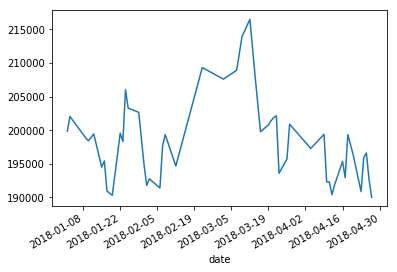

In [30]:
Risk.assets.plot()

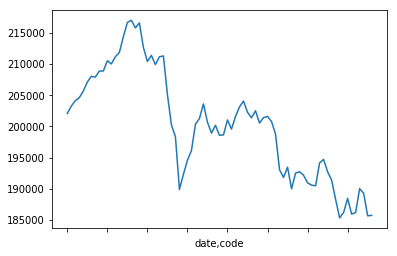

In [31]:
Risk.benchmark_assets.plot()

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

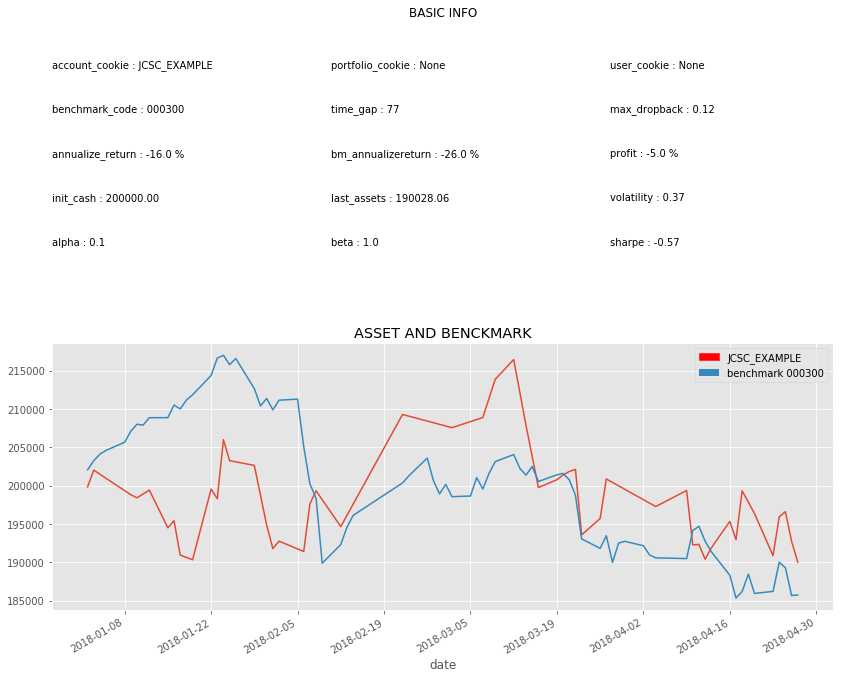

In [32]:
Risk.plot_assets_curve()

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

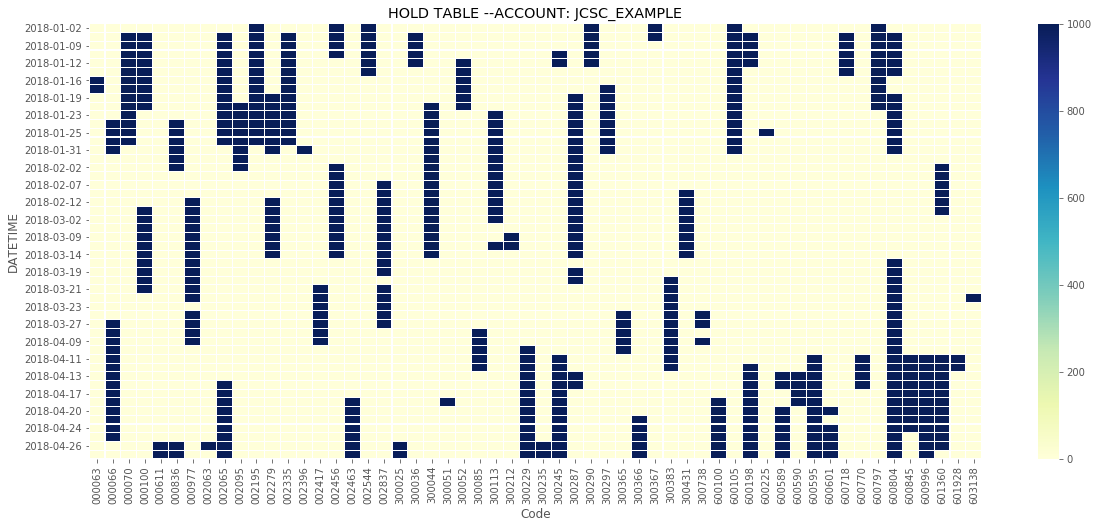

In [33]:
Risk.plot_dailyhold()

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

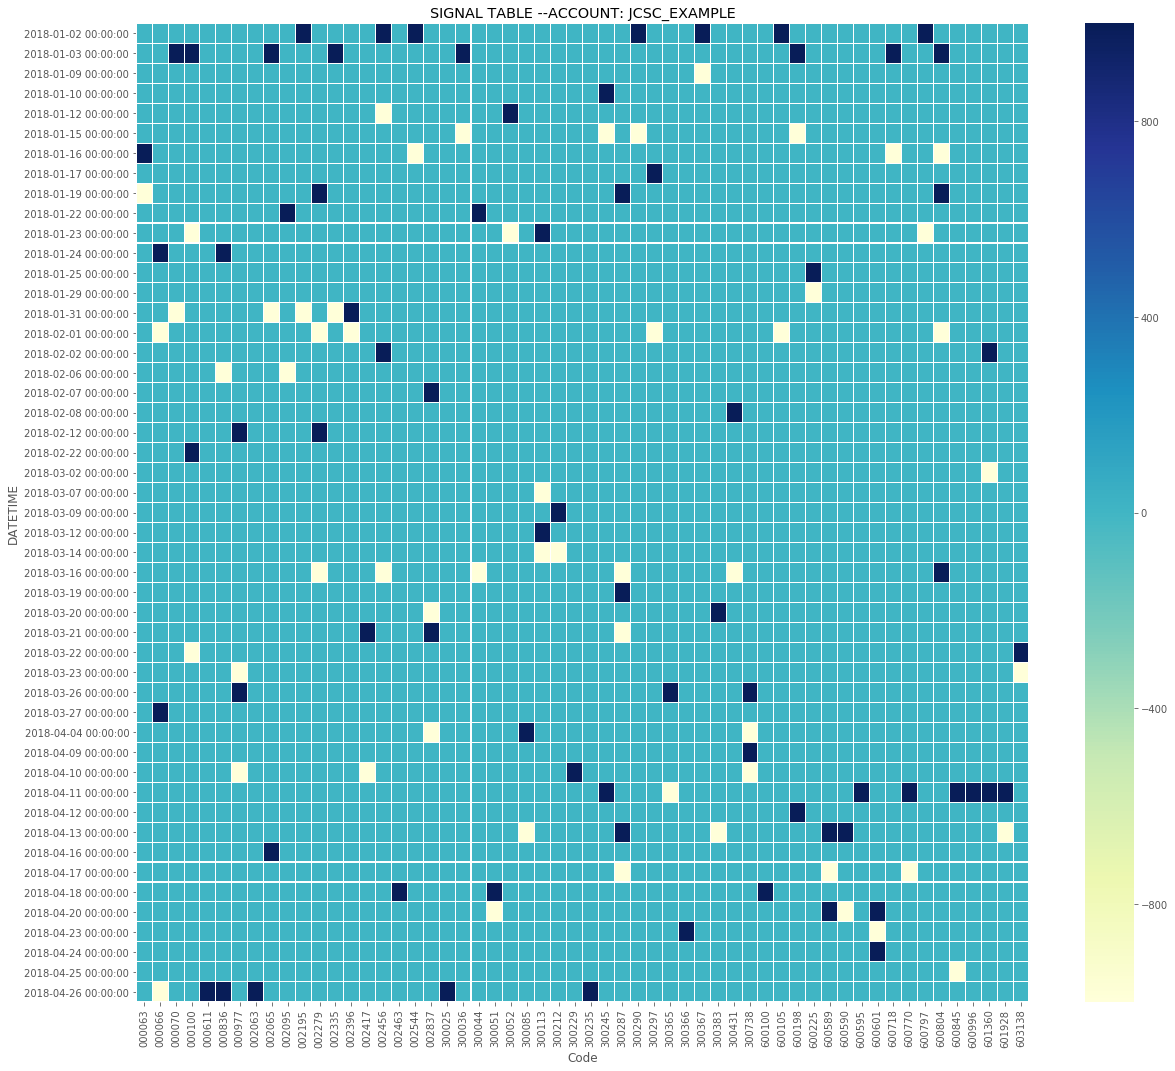

In [34]:
Risk.plot_signal()

In [35]:
Risk.profit_construct

{'total_buyandsell': -9710.0,
 'total_tax': -224.52,
 'total_commission': -37.42,
 'total_profit': -9971.94}

In [36]:
Performance=QA.QA_Performance(Account)

In [46]:
Performance.pnl_fifo

,sell_date,buy_date,amount,sell_price,buy_price,pnl_ratio,pnl_money
code,,,,,,,
300367,2018-01-09,2018-01-02,1000,14.91,15.39,-0.031189,-480.0
002456,2018-01-12,2018-01-02,1000,19.84,20.78,-0.045236,-940.0
300036,2018-01-15,2018-01-03,1000,14.49,15.78,-0.081749,-1290.0
300245,2018-01-15,2018-01-10,1000,13.38,13.80,-0.030435,-420.0
300290,2018-01-15,2018-01-02,1000,8.08,8.71,-0.072331,-630.0
600198,2018-01-15,2018-01-03,1000,10.61,11.65,-0.089270,-1040.0
002544,2018-01-16,2018-01-02,1000,14.62,15.85,-0.077603,-1230.0
600718,2018-01-16,2018-01-03,1000,14.27,15.00,-0.048667,-730.0
600804,2018-01-16,2018-01-03,1000,16.51,17.93,-0.079197,-1420.0


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

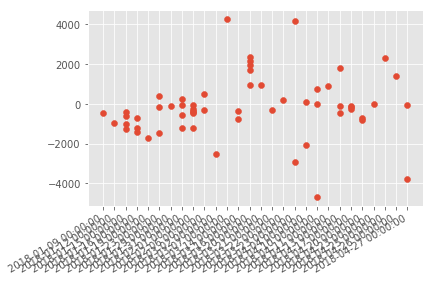

In [45]:
Performance.plot_pnlmoney(Performance.pnl_fifo)

## STEP6: 存储结果

In [39]:
Account.save()
Risk.save()

## STEP7: 查看存储的结果

In [40]:
account_info=QA.QA_fetch_account({'account_cookie':'JCSC_EXAMPLE'})

In [41]:
account=QA.QA_Account().from_message(account_info[0])

In [42]:
account

< QA_Account JCSC_EXAMPLE>